# Tarea Bonus II — Algoritmo Genético para el TSP

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

# Nota: La línea %matplotlib inline hace que las gráficas de matplotlib
# se muestren embebidas en las celdas del notebook.


In [2]:
# --- Paso 3: Defina sus Ciudades ---
# Lista de 7 ciudades con sus coordenadas (x, y).
# Usamos un diccionario para mantener un nombre legible para cada ciudad.
ciudades = {
    'A': (2, 7),
    'B': (8, 1),
    'C': (1, 3),
    'D': (9, 6),
    'E': (5, 5),
    'F': (3, 1),
    'G': (7, 8),
}

# Convertir el diccionario a una lista de coordenadas (útil para cálculos)
# y a una lista de nombres para mapear índices a nombres legibles.
lista_ciudades = list(ciudades.values())
mapa_indices = list(ciudades.keys())
N_CIUDADES = len(lista_ciudades)

print(f"Problema del Vendedor Viajero con {N_CIUDADES} ciudades.")

# --- Funciones Auxiliares (Distancia) ---

def calcular_distancia(p1, p2):
    """Calcula la distancia Euclidiana entre dos puntos (x, y).

    Parámetros:
    - p1, p2: tuplas (x, y)

    Retorna:
    - distancia (float)
    """
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- Paso 4b: Defina la aptitud (distancia total de una ruta) ---
def calcular_aptitud(ruta):
    """
    Calcula la aptitud de una ruta (individuo).
    La aptitud es la distancia total del recorrido.
    Una aptitud más BAJA (distancia corta) es MEJOR.
    """
    distancia_total = 0
    # Sumar distancias entre ciudades consecutivas en la ruta
    for i in range(N_CIUDADES - 1):
        idx_ciudad1 = ruta[i]
        idx_ciudad2 = ruta[i+1]
        distancia_total += calcular_distancia(lista_ciudades[idx_ciudad1], lista_ciudades[idx_ciudad2])

    # Añadir la distancia de regreso al punto de partida para completar el ciclo
    distancia_total += calcular_distancia(lista_ciudades[ruta[-1]], lista_ciudades[ruta[0]])

    return distancia_total

# --- Paso 4a: Crear población inicial ---
def crear_poblacion(tamano_poblacion):
    """
    Crea una población inicial de rutas aleatorias.
    Cada ruta es una permutación de los índices de las ciudades.
    """
    poblacion = []
    indices_base = list(range(N_CIUDADES))
    for _ in range(tamano_poblacion):
        ruta_aleatoria = random.sample(indices_base, N_CIUDADES)
        poblacion.append(ruta_aleatoria)
    return poblacion

# --- Paso 4c: Proceso de selección (Selección de Torneo) ---
def seleccion_torneo(poblacion, aptitudes, tamano_torneo=3):
    """
    Selecciona un individuo 'padre' usando selección de torneo.
    Se eligen K individuos al azar y el mejor (distancia más corta) gana.
    """
    # Seleccionar K índices aleatorios de la población
    indices_torneo = random.sample(range(len(poblacion)), tamano_torneo)

    # Encontrar al mejor individuo (menor aptitud) en el torneo
    mejor_indice = indices_torneo[0]
    for i in indices_torneo[1:]:
        if aptitudes[i] < aptitudes[mejor_indice]:
            mejor_indice = i

    return poblacion[mejor_indice]

# --- Paso 4d (Crossover): Cruce Ordenado (Ordered Crossover - OX1) ---
def cruce_ordenado(padre1, padre2):
    """
    Crea un hijo usando Ordered Crossover (OX1),
    que es ideal para problemas de permutación como el TSP.
    """
    hijo = [-1] * N_CIUDADES

    # Seleccionar dos puntos de cruce aleatorios
    inicio, fin = sorted(random.sample(range(N_CIUDADES), 2))

    # Copiar el segmento del padre1 al hijo
    hijo[inicio:fin] = padre1[inicio:fin]

    # Rellenar los elementos restantes del padre2
    puntero_padre2 = 0
    for i in range(N_CIUDADES):
        if hijo[i] == -1: # Si la ranura está vacía
            while padre2[puntero_padre2] in hijo:
                puntero_padre2 += 1
            hijo[i] = padre2[puntero_padre2]

    return hijo

# --- Paso 4d (Mutación): Mutación por Intercambio (Swap Mutation) ---
def mutacion_intercambio(ruta, tasa_mutacion):
    """
    Introduce una pequeña variación en una ruta.
    Intercambia dos ciudades aleatorias en la ruta con una probabilidad dada.
    """
    if random.random() < tasa_mutacion:
        # Seleccionar dos índices aleatorios para intercambiar
        idx1, idx2 = random.sample(range(N_CIUDADES), 2)
        ruta[idx1], ruta[idx2] = ruta[idx2], ruta[idx1]
    return ruta


Problema del Vendedor Viajero con 7 ciudades.


In [3]:
# --- Paso 4e: Implementar el Algoritmo Genético (Bucle Principal) ---

# Parámetros del Algoritmo Genético (puede modificarlos y re-ejecutar la celda)
TAMANO_POBLACION = 100
GENERACIONES = 500
TASA_MUTACION = 0.05
TAMANO_TORNEO = 5

print("Iniciando Algoritmo Genético...")

# 1. Crear Población Inicial
poblacion = crear_poblacion(TAMANO_POBLACION)

mejor_ruta_global = None
mejor_aptitud_global = float('inf')

# Guardar historial para la gráfica de convergencia
historial_aptitud = []

# 2. Bucle de Evolución
for gen in range(GENERACIONES):

    # Calcular aptitud para toda la población
    aptitudes = [calcular_aptitud(ruta) for ruta in poblacion]

    # Encontrar el mejor de esta generación
    mejor_aptitud_gen = min(aptitudes)
    mejor_ruta_gen = poblacion[np.argmin(aptitudes)]

    # Actualizar el mejor global encontrado
    if mejor_aptitud_gen < mejor_aptitud_global:
        mejor_aptitud_global = mejor_aptitud_gen
        mejor_ruta_global = mejor_ruta_gen

    historial_aptitud.append(mejor_aptitud_global)

    # Crear la nueva generación
    nueva_poblacion = []

    # Elitismo: Mantener al mejor individuo de la generación
    nueva_poblacion.append(mejor_ruta_global)

    # Llenar el resto de la nueva población
    while len(nueva_poblacion) < TAMANO_POBLACION:
        # Selección
        padre1 = seleccion_torneo(poblacion, aptitudes, TAMANO_TORNEO)
        padre2 = seleccion_torneo(poblacion, aptitudes, TAMANO_TORNEO)

        # Cruce
        hijo = cruce_ordenado(padre1, padre2)

        # Mutación
        hijo = mutacion_intercambio(hijo, TASA_MUTACION)

        nueva_poblacion.append(hijo)

    poblacion = nueva_poblacion

    if (gen + 1) % 50 == 0:
        print(f"Generación {gen+1}/{GENERACIONES} | Mejor Distancia: {mejor_aptitud_global:.2f}")


Iniciando Algoritmo Genético...
Generación 50/500 | Mejor Distancia: 27.09
Generación 100/500 | Mejor Distancia: 27.09
Generación 150/500 | Mejor Distancia: 27.09
Generación 200/500 | Mejor Distancia: 27.09
Generación 250/500 | Mejor Distancia: 27.09
Generación 300/500 | Mejor Distancia: 27.09
Generación 350/500 | Mejor Distancia: 27.09
Generación 400/500 | Mejor Distancia: 27.09
Generación 450/500 | Mejor Distancia: 27.09
Generación 500/500 | Mejor Distancia: 27.09



--- ¡Optimización Terminada! ---
Mejor Distancia Total: 27.090
Ruta Óptima: F -> B -> D -> G -> E -> A -> C -> F


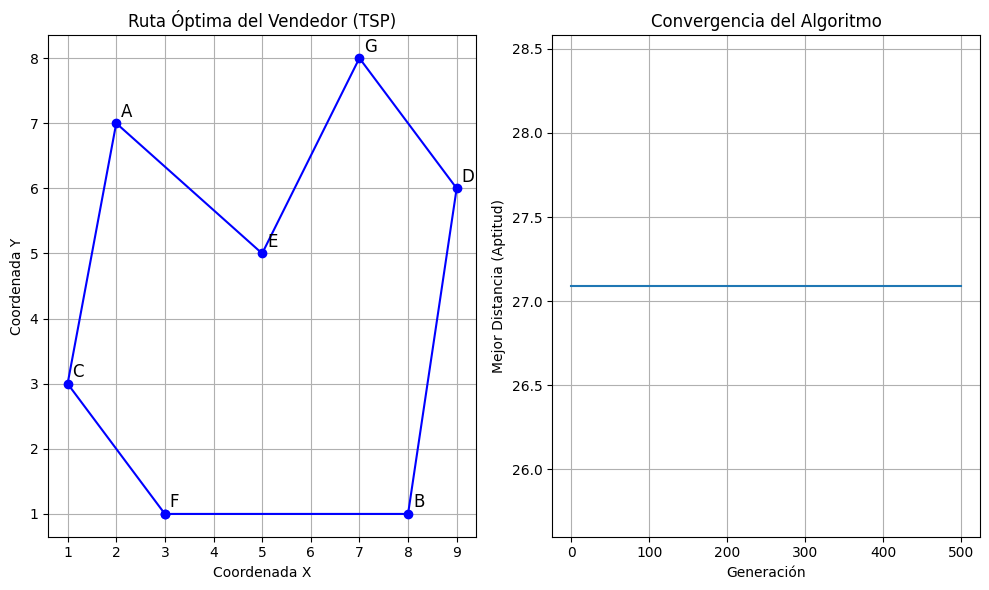

In [4]:
# --- Paso 5: Analizar los resultados ---

# Mapear índices de la ruta óptima a nombres de ciudades
ruta_optima_nombres = [mapa_indices[idx] for idx in mejor_ruta_global]
# Añadir el regreso al inicio para mostrar el ciclo completo
ruta_optima_nombres.append(ruta_optima_nombres[0])

print("\n--- ¡Optimización Terminada! ---")
print(f"Mejor Distancia Total: {mejor_aptitud_global:.3f}")
print(f"Ruta Óptima: {' -> '.join(ruta_optima_nombres)}")

# --- Paso 5: Visualizar la ruta ---
plt.figure(figsize=(10, 6))

# Gráfica 1: Ruta Óptima
plt.subplot(1, 2, 1)
# Dibujar la ruta
coordenadas_ruta = [lista_ciudades[idx] for idx in mejor_ruta_global]
coordenadas_ruta.append(coordenadas_ruta[0]) # Regreso al inicio

x_ruta, y_ruta = zip(*coordenadas_ruta)

plt.plot(x_ruta, y_ruta, 'bo-', label='Ruta Óptima') # 'bo-' = puntos azules con líneas

# Dibujar las ciudades con sus nombres (para facilitar lectura)
for i, nombre in enumerate(mapa_indices):
    plt.text(lista_ciudades[i][0] + 0.1, lista_ciudades[i][1] + 0.1, nombre, fontsize=12)

plt.title('Ruta Óptima del Vendedor (TSP)')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)

# Gráfica 2: Convergencia del Algoritmo
plt.subplot(1, 2, 2)
plt.plot(historial_aptitud)
plt.title('Convergencia del Algoritmo')
plt.xlabel('Generación')
plt.ylabel('Mejor Distancia (Aptitud)')
plt.grid(True)

plt.tight_layout()
plt.show()
